# Rotation of the images of Pic Du Midi



## Import the pipeline

In [892]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [893]:
import os
import pandas as pd
import re
import numpy as np

In [894]:
%matplotlib inline
import matplotlib.pyplot as plt

In [895]:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
#os.chdir(workbookDir)  # If you changed the current working dir, this will take you back to the workbook dir.

workbookDir: /Users/dagoret/MacOSX/GitHub/LSST/Spectractor/notebooks


In [896]:
import sys
sys.path.append(workbookDir)
sys.path.append(os.path.dirname(workbookDir))

In [897]:
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.logbook import LogBook
from spectractor.extractor.images import *
from spectractor import tools
from skimage.feature import hessian_matrix

if __name__ == "__main__":
    from argparse import ArgumentParser

    parser = ArgumentParser()
    parser.add_argument(dest="input", metavar='path', default=["tests/data/reduc_20170605_028.fits"],
                        help="Input fits file name. It can be a list separated by spaces, or it can use * as wildcard.",
                        nargs='*')
    parser.add_argument("-d", "--debug", dest="debug", action="store_true",
                        help="Enter debug mode (more verbose and plots).", default=False)
    parser.add_argument("-v", "--verbose", dest="verbose", action="store_true",
                        help="Enter verbose (print more stuff).", default=False)
    parser.add_argument("-o", "--output_directory", dest="output_directory", default="outputs/",
                        help="Write results in given output directory (default: ./outputs/).")
    parser.add_argument("-l", "--logbook", dest="logbook", default="ctiofulllogbook_jun2017_v5.csv",
                        help="CSV logbook file. (default: ctiofulllogbook_jun2017_v5.csv).")
    parser.add_argument("-c", "--config", dest="config", default="config/ctio.ini",
                        help="INI config file. (default: config.ctio.ini).")
    args = parser.parse_args()


# Configuration

In [898]:
FLAG_ROTATION=False

## Flags

In [899]:
parameters.VERBOSE = True
parameters.DEBUG = True

## Date

In [900]:
#thedate="20190214"
thedate="20190215"

In [901]:
! ls ../*.csv

../ctiofulllogbook_jun2017_V2.csv
../ctiofulllogbook_jun2017_v4.csv
../ctiofulllogbook_jun2017_v5.csv
../simple_logbook_PicDuMidi_20190214.csv
../simple_logbook_PicDuMidi_20190214_rot_v2.csv
../simple_logbook_PicDuMidi_20190214_v2.csv
../simple_logbook_PicDuMidi_20190214_v4.csv
../simple_logbook_PicDuMidi_20190215.csv
../simple_logbook_PicDuMidi_20190215_rot_v2.csv
../simple_logbook_PicDuMidi_20190215_v2.csv
../simple_logbook_PicDuMidi_20190215_v4.csv


## Logbook

In [902]:
if FLAG_ROTATION:
    logbookfilename="../simple_logbook_PicDuMidi_"+thedate+"_rot_v2.csv"
else:
    logbookfilename="../simple_logbook_PicDuMidi_"+thedate+"_v4.csv"
#logbookfilename="../ctiofulllogbook_jun2017_v5.csv" 

### Read the lobook to test

In [903]:
# good for my logbook
df=pd.read_csv(logbookfilename,sep=",", decimal=".", encoding='latin-1', header='infer')

### For example view the first selected filename for a reduced image 

In [904]:
df.file[0]

'T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit'

## Input filename

In [905]:
if thedate=="20190215":
    if FLAG_ROTATION:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v3"
    else:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4"
else:
    if FLAG_ROTATION:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v3"
    else:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v4"

In [906]:
if thedate=="20190215":
    if FLAG_ROTATION:
        file_name="T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_rot.fit"
    else:
        #file_name="T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit"
        file_name="T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit"
else:
    if FLAG_ROTATION:
        file_name="T1M_20190214_234122_495_HD116405-Ronchi_Filtre_None_bin1x1.1_red_rot.fit"
    else:
        file_name="T1M_20190214_234338_976_HD116405-Ronchi_Filtre_None_bin1x1.3_red.fit"
       

## Output directory

In [907]:
output_directory="output/"+thedate

## Config

In [908]:
if FLAG_ROTATION:
    config="../config/picdumidirot.ini"
else:
    config="../config/picdumidi.ini"

# Run Logbook

In [909]:
df=pd.read_csv(logbookfilename)

In [910]:
df.head()

,Unnamed: 0,object,disperser,filt,evnum,flat,airmass,date,exposure,gain,ra,dec,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,file
0,0,HD116405,Holo150PDM19,None,1,FLAT_Filtre_None_bin1x1,1.545961,2019-02-15T22:55:50.730,30.0,4.8,13.379287,44.7106,133.208557,220.874719,50.0,50.0,No,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1,1,HD116405,Holo150PDM19,None,2,FLAT_Filtre_None_bin1x1,1.542936,2019-02-15T22:56:26.007,30.0,4.8,13.379287,44.7106,133.400674,217.612274,50.0,50.0,No,T1M_20190215_225626_007_HD116405_Filtre_None_b...
2,2,HD116405,Holo150PDM19,None,3,FLAT_Filtre_None_bin1x1,1.539925,2019-02-15T22:57:01.284,30.0,4.8,13.379287,44.7106,133.268162,217.954960,50.0,50.0,No,T1M_20190215_225701_284_HD116405_Filtre_None_b...
3,3,HD116405,Holo150PDM19,None,4,FLAT_Filtre_None_bin1x1,1.536929,2019-02-15T22:57:36.562,30.0,4.8,13.379287,44.7106,183.596980,174.983184,50.0,50.0,No,T1M_20190215_225736_562_HD116405_Filtre_None_b...
4,4,HD116405,Holo150PDM19,None,5,FLAT_Filtre_None_bin1x1,1.533947,2019-02-15T22:58:11.838,30.0,4.8,13.379287,44.7106,180.257505,174.547611,50.0,50.0,No,T1M_20190215_225811_838_HD116405_Filtre_None_b...


In [911]:
df.iloc[0]["file"]

'T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit'

In [912]:
logbook = LogBook(logbookfilename)

In [913]:
tag_file=file_name

In [914]:
disperser_label, target, xpos, ypos = logbook.search_for_image(tag_file)

In [915]:
disperser_label

'Holo150PDM19'

In [916]:
target

'HD116405'

In [917]:
xpos,ypos

(133, 220)

In [918]:
fullfilename=os.path.join(INPUTDIR,file_name)

In [919]:
fullfilename

'/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit'

In [920]:
#assert False,"STOP" 

# Run Image

In [921]:
#Spectractor(fullfilename,output_directory, [xpos, ypos], target, disperser_label, config,logbook=logbookfilename)

- Need to specify we use Pic du Midi Observatory
- the logbook filename is hardcoded in Image constructor when calling Image constructor directly

In [922]:
parameters.OBS_NAME = 'PICDUMIDI'

In [923]:
img=Image(fullfilename,target=target,disperser_label=disperser_label,logbook=logbookfilename)

2019-04-12 17:07:06  Image      load_PDM_image       INFO   
	Loading Pic du Midi image /Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit...
2019-04-12 17:07:06  Image      load_PDM_image       INFO   
	Image loaded
2019-04-12 17:07:06  Image      load_LogBook         INFO   
	Load Logbook  ../simple_logbook_PicDuMidi_20190215_v4.csv for /Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit...
2019-04-12 17:07:06  Image      load_LogBook         INFO   
	Load Logbook  : date identified  SEL_DATE=20190215 for imagefile=/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit, FLAG_ROTATION=False...
2019-04-12 17:07:06  Image      load_LogBook         WARNING 
	Load Logbook  :  tag_date = 20190215...
2019-04-12 17:07:06  Image      load_LogBook         WARNING 
	Load Logbook  :  tag_time = 225550...
2019

Load disperser Holo150PDM19:
	from /Users/dagoret/MacOSX/GitHub/LSST/Spectractor/spectractor/extractor/dispersers/Holo150PDM19
Hologram characteristics:
	N = 348.00 +/- 1.14 grooves/mm at plate center
	Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of 45.0 degrees
	Hologram center at x0 = 174.0 and y0 = 208.0 with average tilt of 45.0 degrees
Order  0 position at x0 = -70.5 and y0 = 225.2
Order +1 position at x0 = 418.5 and y0 = 190.8
Distance between the orders: 490.28 pixels (11.77 mm)


2019-04-12 17:07:06  Star       load                 INFO   
	Simbad:  MAIN_ID        RA           DEC      ... SP_TYPE_16 SP_QUAL_16 SP_BIBCODE_16
             "h:m:s"       "d:m:s"    ...                                    
--------- ------------- ------------- ... ---------- ---------- -------------
HD 116405 13 22 45.1237 +44 42 53.911 ...        A0V          C              


Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_003.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_002.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_004.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_001.fits


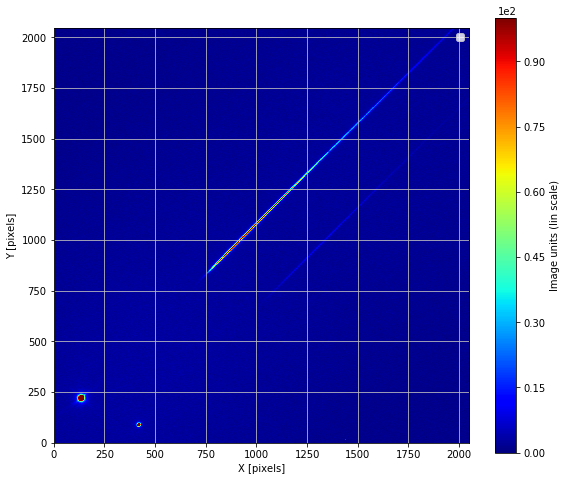

In [924]:
img.plot_image(vmax=100)

# Clean the image around the main dispersion axis

In [925]:
disperser_theta=img.disperser.theta_tilt

In [926]:
disperser_theta

45.0

In [927]:
dw=50

In [928]:
img.target_pixcoords

In [929]:
#x0, y0 = np.array(img.target_pixcoords).astype(int)

In [930]:
data=np.copy(img.data)

In [931]:
x=np.arange(0,data.shape[1])
y=np.arange(0,data.shape[0])

In [932]:
xx, yy = np.meshgrid(x, y)

In [933]:
alpha=disperser_theta/180.*np.pi
x0=xpos
y0=ypos
(x1,y1)=(x0-dw*np.sin(alpha),y0+dw*np.cos(alpha))
(x2,y2)=(x0+dw*np.sin(alpha),y0-dw*np.cos(alpha))

In [934]:
data_clean=np.where(np.logical_and(yy-y1<np.tan(alpha)*(xx-x1),yy-y2>np.tan(alpha)*(xx-x2)),data,0)

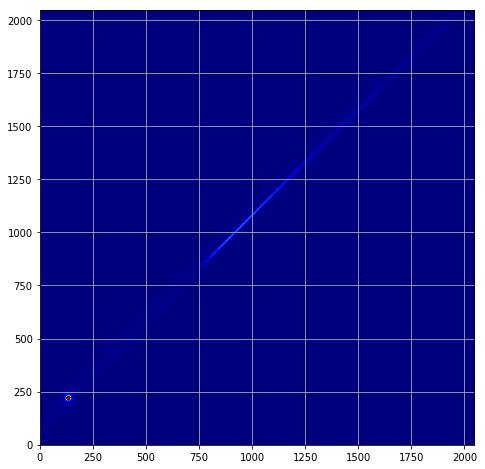

In [935]:
plt.figure(figsize=(8,8))
plt.imshow(data_clean,origin="lower",cmap="jet",vmax=500)
plt.grid(True)

In [936]:
data_clean_cut=np.copy(data_clean[500:,500:])

# Check how the target is calculated

2019-04-12 17:07:16  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 2
Parameters:
           c0_0               c1_0        ...          c1_1        
    ------------------ ------------------ ... ---------------------
    2.1053007129758345 0.3441275234969412 ... 0.0028841949977671468
2019-04-12 17:07:16  Image      find_target_2Dprofile INFO   
	185 saturated pixels: set saturation level to 2000.0 ADU/s.
2019-04-12 17:07:16  spectractor.extractor.psf fit_PSF2D_minuit     DEBUG  
[ 1.94685382e+03  4.78493313e+01  4.97196380e+01  5.33166719e+00
  1.62298467e+00 -2.29110794e+00  1.76261803e+00  2.00000000e+03]
2019-04-12 17:07:16  spectractor.extractor.psf fit_PSF2D_minuit     DEBUG  
	PSF best fitting parameters:
Model: PSF2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean      ...       stddev       saturation
    ------------------ --------------

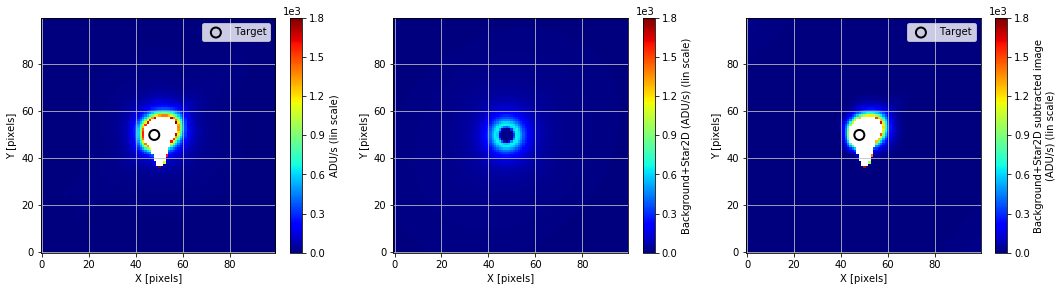

2019-04-12 17:07:18  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 2
Parameters:
           c0_0              c1_0       ...         c0_2                c1_1       
    ----------------- ----------------- ... ------------------- -------------------
    5.623656793587947 6.116997001942129 ... -0.2212943726000861 0.16050066188258608
2019-04-12 17:07:18  Image      find_target_2Dprofile INFO   
	185 saturated pixels: set saturation level to 2000.0 ADU/s.
2019-04-12 17:07:18  spectractor.extractor.psf fit_PSF2D_minuit     DEBUG  
[ 2.00000000e+04  2.83190249e+01  2.71093684e+01  1.41450587e+01
  1.00000000e+01 -1.36258042e+00  2.71550740e+00  2.00000000e+03]
2019-04-12 17:07:18  spectractor.extractor.psf fit_PSF2D_minuit     DEBUG  
	PSF best fitting parameters:
Model: PSF2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude           x_mean       ...       stddev       

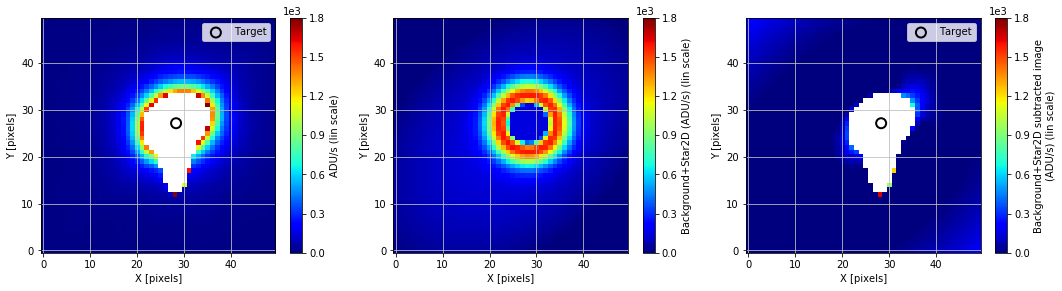

2019-04-12 17:07:19  Image      find_target          INFO   
	X,Y target position in pixels: 133.319,221.109


In [937]:
 target_pixcoords = find_target(img, (x0,y0))

# Do the rotation à la spectractor

2019-04-12 17:07:19  Image      turn_image           INFO   
	turn_image :: width_cut=50...
2019-04-12 17:07:19  Image      compute_rotation_angle_hessian INFO   
	 compute_rotation_angle_hessian, width_cut=50....,deg_threshold=10......
2019-04-12 17:07:19  Image      compute_rotation_angle_hessian INFO   
	 compute_rotation_angle_hessian : DO PERFORM rotation for Pic Du Midi !!!! ......
2019-04-12 17:07:19  Image      compute_rotation_angle_hessian INFO   
	 compute_rotation_angle_hessian, x0 = 133 pix, y0 = 221 pix, theta_disp = 45.0 deg......
2019-04-12 17:07:19  Image      compute_rotation_angle_hessian WARNING 
	compute_rotation_angle_hessian :: call hessian_and_theta with margin_cut = 12...
2019-04-12 17:07:19  Image      compute_rotation_angle_hessian WARNING 
	compute_rotation_angle_hessian :: hessian_and_theta found lambda_threshold=-81.10964158417593 ...


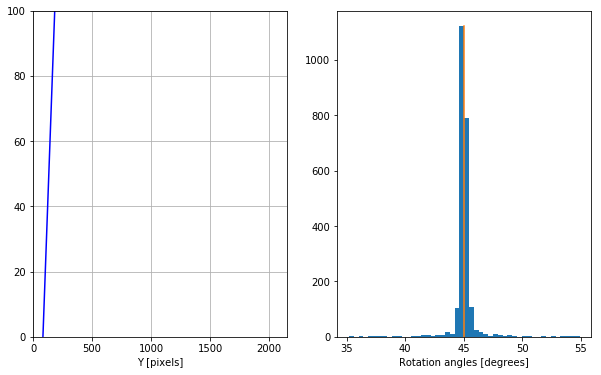

2019-04-12 17:07:20  Image      turn_image           INFO   
	turn_image ::  Rotate the image with angle theta=45.00 degree


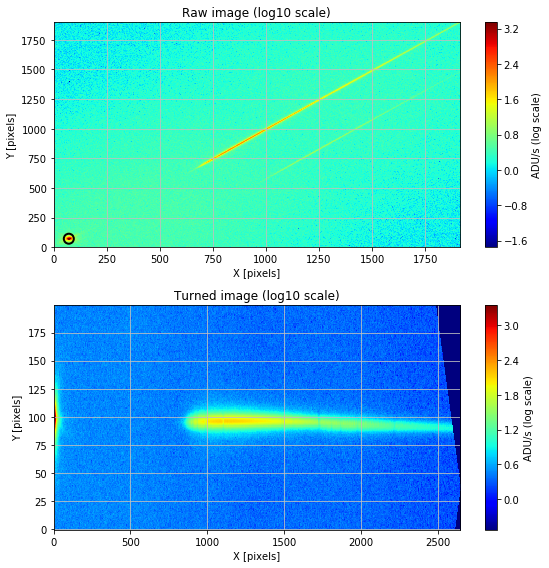

In [938]:
turn_image(img)

## Try on cut image

In [956]:
lambda_plus, lambda_minus, theta = tools.hessian_and_theta(data_clean, 12)

Text(0.5, 1.0, 'hessian_and_theta : theta')

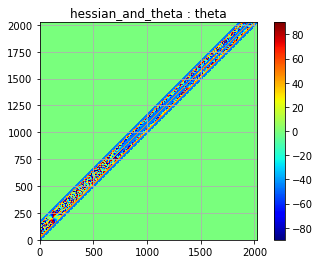

In [957]:
img=plt.imshow(theta,origin="lower",cmap="jet");
plt.grid()
plt.colorbar(img)
plt.title("hessian_and_theta : theta")

Text(0.5, 1.0, 'hessian_and_theta : theta')

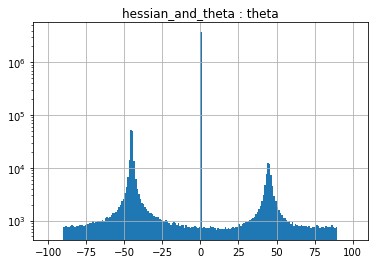

In [958]:
plt.hist(theta.flatten(),bins=200,range=(-100,100));
plt.yscale('log')
plt.grid()
plt.title("hessian_and_theta : theta")

Text(0.5, 1.0, 'hessian_and_theta : $\\lambda$ +')

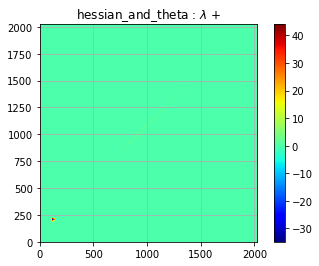

In [959]:
img=plt.imshow(lambda_plus,origin="lower",cmap="jet");
plt.grid()
plt.colorbar(img)
plt.title("hessian_and_theta : $\lambda$ +")

Text(0.5, 1.0, 'hessian_and_theta : $\\lambda$ +')

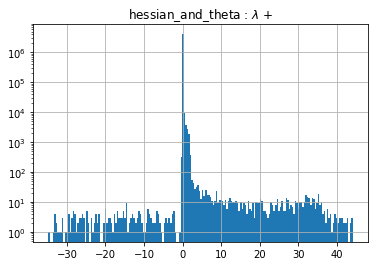

In [960]:
plt.hist(lambda_plus.flatten(),bins=200);
plt.yscale('log')
plt.grid()
plt.title("hessian_and_theta : $\lambda$ +")

Text(0.5, 1.0, 'hessian_and_theta : $\\lambda$ -')

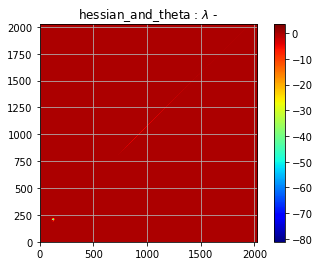

In [961]:
img=plt.imshow(lambda_minus,origin="lower",cmap="jet");
plt.grid()
plt.colorbar(img)
plt.title("hessian_and_theta : $\lambda$ -")

Text(0.5, 1.0, 'hessian_and_theta : $\\lambda$ -')

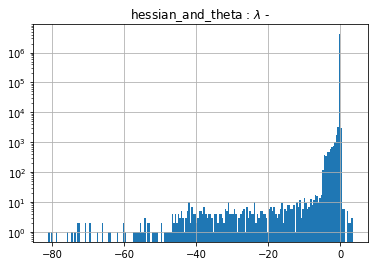

In [962]:
plt.hist(lambda_minus.flatten(),bins=200);
plt.yscale('log')
plt.grid()
plt.title("hessian_and_theta : $\lambda$ -")

# Alternative

In [963]:
lambda_minus.flatten().min()

-81.10964158417593

In [964]:
lambda_threshold = np.min(lambda_minus.flatten())

In [965]:
lambda_threshold

-81.10964158417593

In [966]:
width_cut=100
right_edge=2000

In [967]:
mask = np.where(lambda_minus > lambda_threshold)

theta_mask = np.copy(theta)
theta_mask[mask] = np.nan

minimum_pixels = 0.01 * 2 * width_cut * right_edge

In [968]:
minimum_pixels

4000.0

In [969]:
while len(theta_mask[~np.isnan(theta_mask)]) < minimum_pixels:
    lambda_threshold /= 2
    mask = np.where(lambda_minus > lambda_threshold)
    theta_mask = np.copy(theta)
    theta_mask[mask] = np.nan
    print(len(theta_mask[~np.isnan(theta_mask)]), lambda_threshold)



108 -40.554820792087966
306 -20.277410396043983
446 -10.138705198021992
586 -5.069352599010996
2954 -2.534676299505498
5396 -1.267338149752749


In [970]:
#theta_guess = img.disperser.theta(image.target_pixcoords)
theta_guess = disperser_theta

In [971]:
mask2 = np.where(np.abs(theta - theta_guess) > 10)
theta_mask[mask2] = np.nan
theta_mask = theta_mask[2:-2, 2:-2]
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()

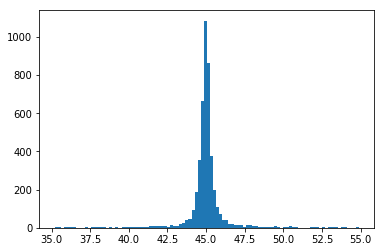

In [972]:
plt.hist(theta_hist,bins=100);